##  Описание проекта
Нас пригласили на стажировку в отдел маркетинговой аналитики Яндекс.Афиши. Первое задание: помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет.
Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Нам предстоит изучить:
- как клиенты пользуются сервисом,
- когда делают первые покупки на сайте,
- сколько денег приносит компании каждый клиент,
- когда расходы на привлечение клиента окупаются.
Выручка измеряется в условных единицах — у.е.

## Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):

- Uid — уникальный id пользователя;
- Device — тип устройства пользователя;
- Start Ts — дата и время начала сессии;
- End Ts — дата и время окончания сессии;
- Source Id — id рекламного источника, из которого пришел пользователь.

Таблица orders (информация о заказах):

- Uid — уникальный id пользователя, который сделал заказ;
- Buy Ts — дата и время заказа;
- Revenue — выручка J.K. с этого заказа.

Таблица costs (информация о затратах на маркетинг):

- source_id — id рекламного источника;
- dt — дата;
- costs — затраты на этот рекламный источник в этот день.

## Открытие данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
display(visits.sample(10))
visits.info()

,Device,End Ts,Source Id,Start Ts,Uid
330068,touch,2018-05-19 00:20:00,5,2018-05-19 00:17:00,1072550696298872839
44410,desktop,2017-11-24 15:20:00,3,2017-11-24 15:17:00,14471316845793743762
254369,desktop,2017-12-04 20:48:00,5,2017-12-04 20:41:00,6070911561076415390
243261,desktop,2018-04-12 20:38:00,3,2018-04-12 20:35:00,12924785566922738913
151787,touch,2017-12-22 07:17:00,4,2017-12-22 07:12:00,11390430255818047667
307066,touch,2018-01-15 20:11:00,2,2018-01-15 19:51:00,7142179484644071870
52202,desktop,2017-08-21 09:10:00,9,2017-08-21 09:08:00,7486831296002298719
303477,touch,2018-04-19 14:21:00,4,2018-04-19 14:21:00,12638720838342274692
29731,desktop,2018-01-12 02:18:00,3,2018-01-12 02:03:00,17345378685944799325
45212,desktop,2017-06-21 23:01:00,3,2017-06-21 22:58:00,9103106784809994861


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
orders = pd.read_csv('/datasets/orders_log.csv')
display(orders.sample(10))
orders.info()

,Buy Ts,Revenue,Uid
17245,2017-11-13 10:48:00,8.43,6731421022966725351
5640,2017-08-19 17:55:00,5.50,11168671023925403279
20840,2017-11-28 23:16:00,8.55,140130419520596980
29449,2018-01-15 12:11:00,3.48,774976817171856731
9481,2017-09-28 15:41:00,5.83,8964545476361898274
7581,2017-09-12 17:05:00,3.05,2732812963416799051
30692,2018-01-23 16:23:00,2.39,10709119566524452981
36168,2018-02-21 15:00:00,3.05,7514025287786843241
5780,2017-08-22 12:49:00,5.50,5620607365290116776
49946,2018-05-31 10:29:00,6.60,10539822438259577232


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [4]:
costs = pd.read_csv('/datasets/costs.csv')
display(costs.sample(10))
costs.info()

,source_id,dt,costs
445,2,2017-08-22,52.39
927,3,2017-12-19,218.25
1712,5,2018-02-16,148.87
2199,10,2017-06-21,9.83
940,3,2018-01-01,364.64
200,1,2017-12-18,87.79
797,3,2017-08-11,165.68
850,3,2017-10-03,620.70
2116,9,2018-03-28,20.59
259,1,2018-02-15,129.46


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### Вывод

При анализе данных в таблице критических ошибок не найдено, пропуски отсутствуют, следует только поменять тип данных некоторых столбцов на тип данных date.

## Предобработка данных

In [5]:
costs.duplicated().sum()

0

In [6]:
visits.duplicated().sum()

0

In [7]:
orders.duplicated().sum()

0

Дубликаты отсутствуют

In [8]:
visits.columns = visits.columns.str.lower() #Приводим названия столбцов к нижнему регистру
orders.columns = orders.columns.str.lower()

Поменяем тип данных на date

In [9]:
visits['start ts'] = pd.to_datetime(visits['start ts'])
visits['end ts'] = pd.to_datetime(visits['end ts'])
orders['buy ts'] = pd.to_datetime(orders['buy ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

In [10]:
visits.columns = ['device', 'end ts', 'source_id', 'start ts', 'uid']

### Вывод

## Продуктовые метрики

In [11]:
# Найдем средние dau, wau и mau
visits['year']  = visits['start ts'].dt.year
visits['month'] = visits['start ts'].dt.month
visits['week']  = visits['start ts'].dt.week
visits['date'] = visits['start ts'].dt.date

dau = visits.groupby('date').agg({'uid': 'nunique'}).mean()
wau = visits.groupby(['year', 'week']).agg({'uid': 'nunique'}).mean()
mau = visits.groupby(['year', 'month']).agg({'uid': 'nunique'}).mean()
print(int(dau))
print(int(wau))
print(int(mau))

907
5716
23228


In [12]:
dau1 = visits.groupby('date').agg({'uid': 'nunique'})
wau1 = visits.groupby('week').agg({'uid': 'nunique'})
mau1 = visits.groupby('month').agg({'uid': 'nunique'})

/opt/conda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


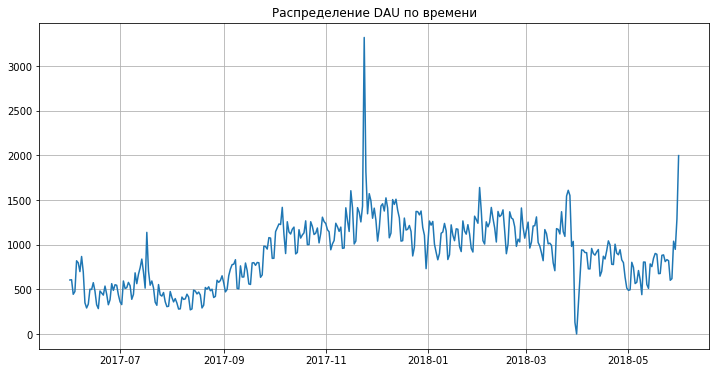

In [13]:
plt.figure(figsize=(12, 6))
plt.title('Распределение DAU по времени')
plt.plot(dau1['uid'])
plt.grid()
plt.show()

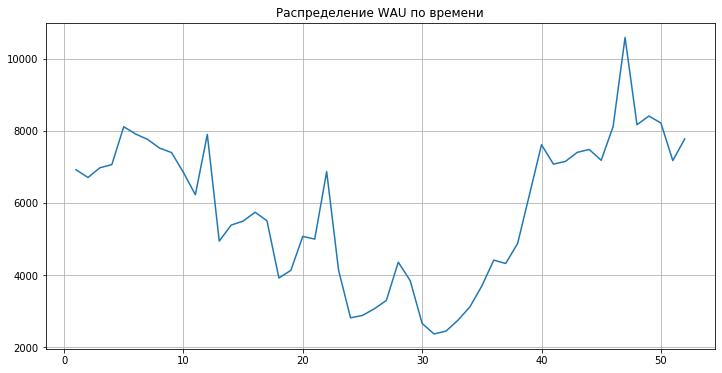

In [14]:
plt.figure(figsize=(12, 6))
plt.title('Распределение WAU по времени')
plt.plot(wau1['uid'])
plt.grid()
plt.show()

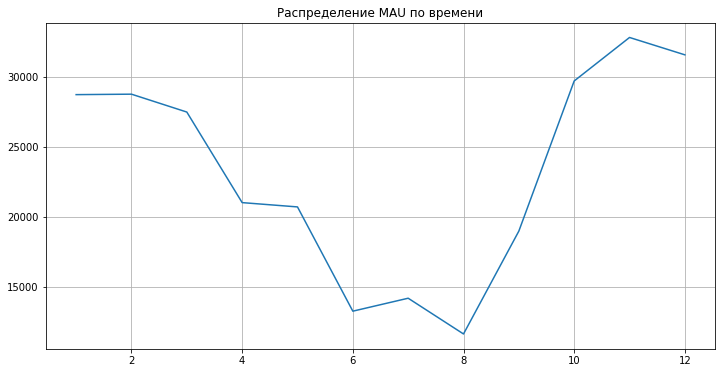

In [15]:
plt.figure(figsize=(12, 6))
plt.title('Распределение MAU по времени')
plt.plot(mau1['uid'])
plt.grid()
plt.show()

In [16]:
# Найдем сколько в среднем за день люди заходят на сайт
visits_per_user = visits.groupby('date').agg({'uid': ['count','nunique']})
visits_per_user.columns = ['n_sessions', 'n_users']
visits_per_user['sessions_per_user'] = visits_per_user['n_sessions'] / visits_per_user['n_users']
print(visits_per_user['sessions_per_user'].mean())

1.082169644003972


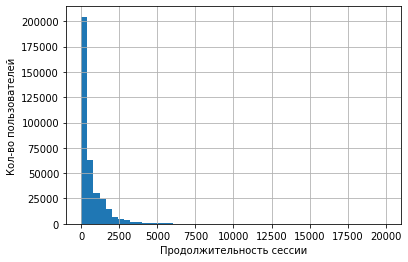

0    60
dtype: int64


In [17]:
# Исследуем продолжительность сессий на сайте
visits['session_duration_sec'] = (visits['end ts'] - visits['start ts']).dt.seconds
visits['session_duration_sec'].plot(kind = 'hist', bins = 50, grid = True, range = (0, 20000))
plt.xlabel("Продолжительность сессии")
plt.ylabel("Кол-во пользователей")
plt.show()
print(visits['session_duration_sec'].mode()) #Cредняя продолжительность сессии

Рассчитаем Retention Rate для посещений на сайт

In [18]:
first_activity_date = visits.groupby(['uid'])['start ts'].min()
first_activity_date.name = 'first_visit_date'
visits = visits.join(first_activity_date, on = 'uid')

In [19]:
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits['visit_month'] = visits['start ts'].astype('datetime64[M]')

In [20]:
visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [21]:
cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum') 
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
cohorts.groupby('first_visit_month').agg({'retention': 'sum'})

,retention
first_visit_month,
2017-06-01,1.641376
2017-07-01,1.455936
2017-08-01,1.426382
2017-09-01,1.365481
2017-10-01,1.278015
2017-11-01,1.240018
2017-12-01,1.164200
2018-01-01,1.144272
2018-02-01,1.102626


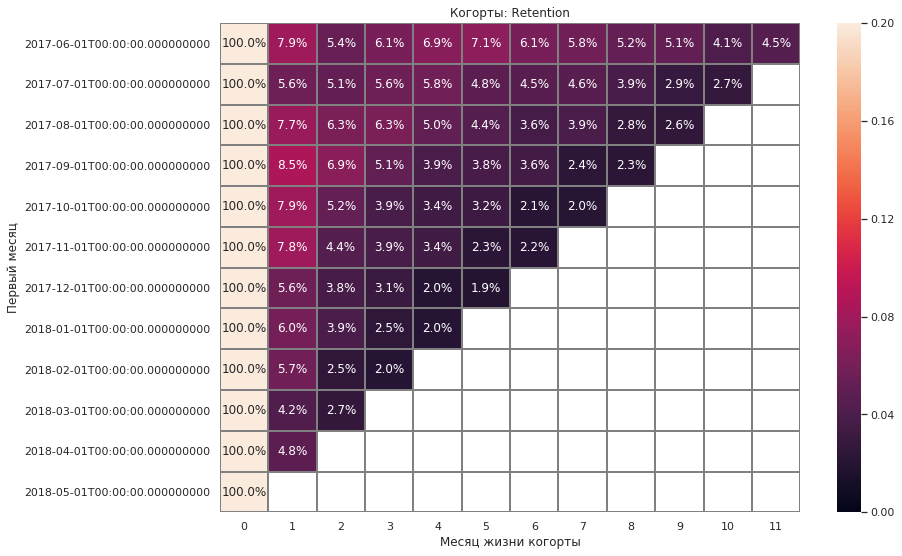

In [23]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты: Retention')
sns.heatmap(retention_pivot, annot=True, vmin = 0, vmax = 0.2, fmt='.1%', linewidths=1, linecolor='gray')
plt.xlabel("Месяц жизни когорты")
plt.ylabel("Первый месяц")
plt.show()

In [24]:
#Найдем средний Retention Rate для 2-ого месяца жизни когорт
cohorts[cohorts['cohort_lifetime'] == 1].groupby('cohort_lifetime')['retention'].mean()

cohort_lifetime
1    0.065167
Name: retention, dtype: float64

### Вывод

Обозначим результаты для продуктовых метрик. DAU: 907 пользователей, WAU: 5716 пользователя, MAU: 23228 пользователей. Также мы узнали, что в среднем в день пользователи заходят 1 раз на сайт. Продолжительность основной части сессий варируется от 0 до 1 минуты, следовательно, обычно люди заходят на сайт и сразу уходят с него. Перейдем к Retention, показатель Retention довольно низок, т.к. максимальное значение не превышает 9%. Средний Retention Rate для 2-ого месяца жизни когорт составляет 6.5%. И можно заметить, что при дальнейшей жизни когорты Retention Rate стремительно уменьшается и в итоге достигает 2-3%. В конце отметим, что самые высокие значения Retention имеет первая когорта.

## Метрики электронной коммерции

Исследуем, сколько в среднем времени проходит с момента первого посещения сайта до совершения покупки

In [25]:
first_orders = orders.groupby('uid')['buy ts'].min()
first_visit = visits[['uid', 'first_visit_date']]
first_visit_order = first_visit.merge(first_orders, on = 'uid', how = 'left').dropna()

In [26]:
first_visit_order['time_diff'] = first_visit_order['buy ts'] - first_visit_order['first_visit_date']
first_visit_order['time_diff'] = first_visit_order['time_diff'] / np.timedelta64(1,'m')
first_visit_order['time_diff'] = first_visit_order['time_diff'].round(1)

In [27]:
first_visit_order = first_visit_order.drop_duplicates()
first_visit_order

,uid,first_visit_date,buy ts,time_diff
3,16174680259334210214,2018-03-09 20:05:00,2018-03-09 20:25:00,20.0
5,16007536194108375387,2017-09-03 21:35:00,2017-09-04 12:46:00,911.0
12,8056418121947262981,2017-06-04 14:17:00,2017-06-25 08:54:00,29917.0
15,18188358787673499603,2018-02-10 12:17:00,2018-02-12 19:48:00,3331.0
25,2307401184189569202,2017-09-23 23:27:00,2017-09-27 09:23:00,4916.0
...,...,...,...,...
358438,6752020629696526518,2017-12-04 12:42:00,2017-12-04 12:46:00,4.0
358447,11750532881998794555,2017-11-20 23:33:00,2017-11-20 23:43:00,10.0
358484,11202626539189016002,2017-11-29 20:27:00,2017-11-29 20:33:00,6.0
358517,12734910664455613822,2018-04-23 21:11:00,2018-04-23 21:16:00,5.0


In [28]:
min_time_diff = first_visit_order.groupby('uid')[['time_diff']].min()

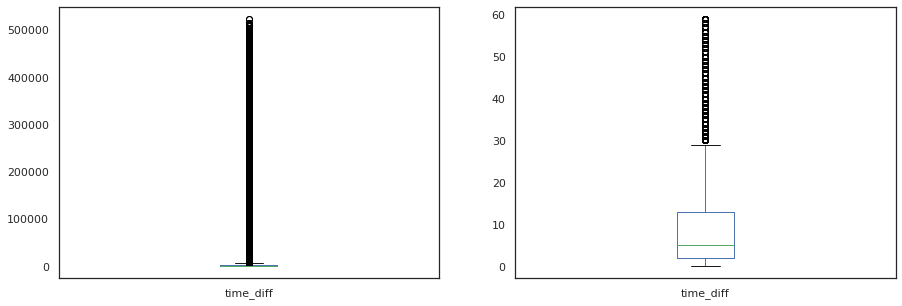

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
min_time_diff.plot(kind='box', ax=axes[0])
min_time_diff.query('time_diff < 60').plot(kind='box', ax=axes[1])
plt.show()

Выбросы наблюдаются после 30 минут разницы 

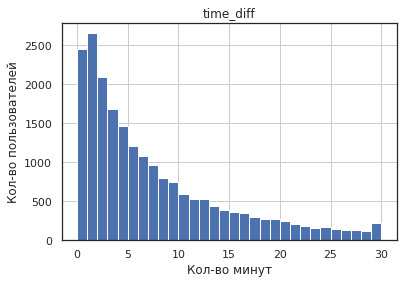

In [30]:
title = "Гистограмма распределения разницы между временем первого заказа и началом первой сессии"
first_order_hist = min_time_diff.query('time_diff <= 30').hist(bins=30)
plt.xlabel("Кол-во минут")
plt.ylabel("Кол-во пользователей")
plt.show()

In [31]:
min_time_diff.query('time_diff <= 30').mean()

time_diff    7.061977
dtype: float64

Посчитаем среднее кол-во покупок на 1 покупателя за 6 месяцев.

In [32]:
first_orders.name = 'first_buy_ts'
orders = orders.join(first_orders, on = 'uid')

In [33]:
orders['time_to_buy'] = orders['buy ts'] - orders['first_buy_ts']
orders['time_to_buy'] = orders['time_to_buy'] / np.timedelta64(1,'M')
orders['time_to_buy'] = orders['time_to_buy'].astype('int')
filtered_buy = orders[orders['time_to_buy'] < 6]
filtered_buy

,buy ts,revenue,uid,first_buy_ts,time_to_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,0
...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31 23:50:00,0
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31 23:50:00,0
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31 23:54:00,0
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31 23:56:00,0


In [34]:
count_buy_by_users = filtered_buy.groupby(['uid']).agg({'buy ts':'count'}).reset_index()
count_buy_by_users.sort_values(by = 'buy ts', ascending = False)

,uid,buy ts
27482,13888745432979765063,160
13459,6731421022966725351,145
7206,3644482766749211722,132
20471,10343016064897450067,127
23600,11920452646463905188,121
...,...,...
13289,6639463736145804561,1
13288,6639158731782521409,1
13287,6639055814818614474,1
13286,6638652321977153945,1


In [35]:
count_buy_by_users['buy ts'].mean()

1.3328039865290364

В среднем за 6 месяцев покупатели совершают 1 покупку.

Посчитаем средний чек

In [36]:
orders['first_order_month'] = orders['first_buy_ts'].astype('datetime64[M]')
orders['order_month'] = orders['buy ts'].astype('datetime64[M]')
orders_revenue = orders.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum', 'uid': 'nunique'})
orders_revenue['revenue_per_user'] = orders_revenue['revenue'] / orders_revenue['uid']
orders_revenue

revenue   uid  revenue_per_user
first_order_month order_month                                  
2017-06-01        2017-06-01    9557.49  2023          4.724414
                  2017-07-01     981.82    61         16.095410
                  2017-08-01     885.34    50         17.706800
                  2017-09-01    1931.30    54         35.764815
                  2017-10-01    2068.58    88         23.506591
...                                 ...   ...               ...
2018-03-01        2018-05-01    1114.87    58         19.221897
2018-04-01        2018-04-01   10600.69  2276          4.657597
                  2018-05-01    1209.92    69         17.535072
2018-05-01        2018-05-01   13925.76  2988          4.660562
2018-06-01        2018-06-01       3.42     1          3.420000

[79 rows x 3 columns]

In [37]:
orders_revenue.groupby('first_order_month').agg({'revenue_per_user': 'sum'})

,revenue_per_user
first_order_month,
2017-06-01,258.065647
2017-07-01,110.235367
2017-08-01,121.128106
2017-09-01,281.366965
2017-10-01,58.838414
2017-11-01,51.393936
2017-12-01,151.005650
2018-01-01,41.121729
2018-02-01,24.650427


In [38]:
orders_revenue_pivot = orders_revenue.pivot_table(index = 'first_order_month', columns = 'order_month', values = 'revenue_per_user', aggfunc = 'mean')

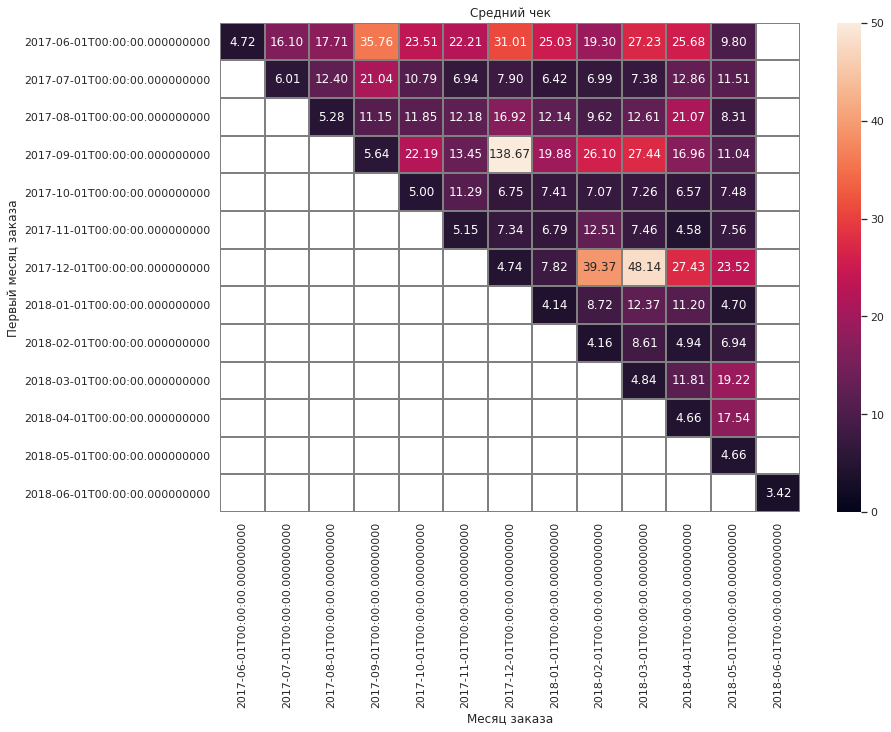

In [39]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний чек')
sns.heatmap(orders_revenue_pivot, annot=True, vmin = 0, vmax = 50, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel("Месяц заказа")
plt.ylabel("Первый месяц заказа")
plt.show()

In [40]:
orders['revenue'].mean()

4.999646930477041

Cредний чек по всем покупателям составляет почти 5 у.е. Также стоит отметить, что в первый месяц пользователи не делают крупных покупок, но со временем их чек увеличивается. И можно обратить внимание на аномально большие чеки для 4 и 7 когорты, странно, что чек увеличился резко в несколько раз. 1-ая и 4-ая когорта имеют самые большие средние чеки.

Исследуем LTV для когорт, которые прожили не менее 6 месяцев.

In [41]:
cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

In [42]:
cohorts1 = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

In [43]:
report = pd.merge(cohort_sizes, cohorts1, on='first_order_month')
report

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58
...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87
75,2018-04-01,2276,2018-04-01,10600.69
76,2018-04-01,2276,2018-05-01,1209.92
77,2018-05-01,2988,2018-05-01,13925.76


In [44]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['ltv'] = report['revenue'] / report['n_buyers']
report_age = report.groupby('first_order_month').agg({'age' : 'max'})
report_age = report_age[report_age['age'] >= 6] 
report_age

,age
first_order_month,
2017-06-01,11
2017-07-01,10
2017-08-01,9
2017-09-01,8
2017-10-01,7
2017-11-01,6


In [45]:
report1 = report[(report['first_order_month'] <= '2017-11-01') & (report['age'] <= 6)]
report1

,first_order_month,n_buyers,order_month,revenue,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,4,1.022531
5,2017-06-01,2023,2017-11-01,1487.92,5,0.735502
6,2017-06-01,2023,2017-12-01,1922.74,6,0.950440
12,2017-07-01,1923,2017-07-01,11557.65,0,6.010218
13,2017-07-01,1923,2017-08-01,644.61,1,0.335211
14,2017-07-01,1923,2017-09-01,1199.05,2,0.623531


In [46]:
result = report1.pivot_table(index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
result

age,0,1,2,3,4,5,6
first_order_month,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440
2017-07-01,6.010218,0.335211,0.623531,0.358976,0.176791,0.156048,0.120208
2017-08-01,5.276518,0.471993,0.458482,0.391277,0.494051,0.283540,0.210664
2017-09-01,5.644529,1.117586,0.520930,3.975792,0.400558,0.647067,0.701608
2017-10-01,5.003733,0.535763,0.191394,0.157145,0.151560,0.120362,0.084816
2017-11-01,5.154683,0.399233,0.199556,0.324952,0.148013,0.053879,0.114928


In [47]:
report1.groupby('first_order_month').agg({'ltv': 'sum'})

,ltv
first_order_month,
2017-06-01,9.310524
2017-07-01,7.780983
2017-08-01,7.586526
2017-09-01,13.008071
2017-10-01,6.244772
2017-11-01,6.395244


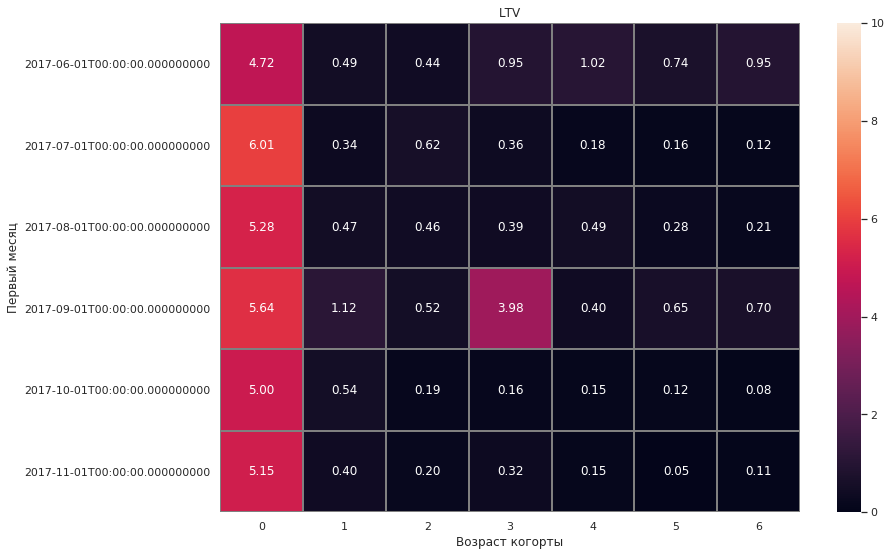

In [48]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(result, annot=True, vmin = 0, vmax = 10, fmt='.2f', linewidths=1, linecolor='gray');
plt.xlabel("Возраст когорты")
plt.ylabel("Первый месяц")
plt.show()

Можно сделать вывод, что самые прибыльные месяца - первые в жизни когорт. Данную тенденцию можно объяснить, что люди редко покупают билеты на мероприятия и в дальнейшим остаются истинные ценители. Также можно заметить особенность в том, что на 4-ом месяце жизни когорт ltv не привышает 1, а у 4-ой когорты ltv практически равна 4, это довольно высокий показатель по сравнению с другими когортами. И отметим, что самые большие показатели ltv у 1-ой и 4-ой когорты. 

### Вывод

В данной части работы мы затронули метрики электронной коммерции. Мы узнали, что в среднем проходит 7 минут между 1-ым посещением и 1-ой покупкой. Обычно пользователи совершают 1 покупку за 6 месяцев. Нашли средний чек, который примерно равен 15 у.е., а также рассмотрели средний чек по когортам и узнали, что самые крупные чеки у 1-ой и 4-ой. И в конце оценили ltv у когорт, которые прожили не менее 6 месяцев и сделали следующие выводы. Первый месяц когорт самый прибыльный. Также отметили, что у 4-ой когорты необычно высокий ltv для 4-ого месяца жизни по сравнению с другими когортами. И отметили, что самые большие показатели ltv у 1-ой и 4-ой когорты.

## Маркетинговые метрики

Общая сумма расходов и распределение по источникам

In [49]:
print(costs.groupby('source_id')['costs'].sum())
print(costs['costs'].sum())

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64
329131.62


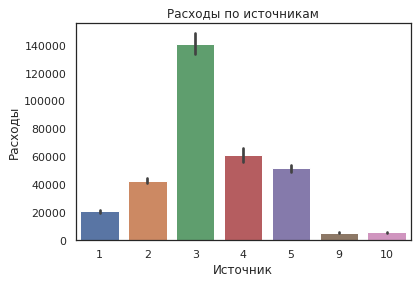

In [50]:
sns.barplot(x='source_id', y='costs', data=costs, estimator=sum)
plt.title('Расходы по источникам')
plt.xlabel("Источник")
plt.ylabel("Расходы")
plt.show()

Лидер по расходам является 3 источник.

Перейдем к САС

In [51]:
all_costs = costs['costs'].sum()
all_buyers = orders['uid'].nunique()
all_sas = all_costs / all_buyers
print(all_sas) #Нашли средний САС по каждому покупателю для всего проекта
all_revenue = orders['revenue'].sum()
all_ltv = all_revenue / all_buyers
print(all_ltv)

9.011626098622786
6.9013279303452615


Если оценивать весь проект, то затраты превышают выручку, значит Яндекс Афиша работает в убыль. Эту проблему надо будет решить.

Рассмотрим САС для каждого источника

In [52]:
visits_sorted = visits.sort_values(by='start ts')
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})

first_source_per_user = visits_sorted.groupby('uid').agg({'source_id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='uid')
client_per_source = client_per_source.groupby('source_id').agg({'uid': 'nunique'})

uid_per_source = visits_sorted.groupby('source_id').agg({'uid': 'nunique'})

In [53]:
rev_per_source = orders.merge(first_source_per_user, on='uid')
rev_per_source = rev_per_source.groupby('source_id').agg({'revenue': 'sum'})

In [54]:
rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()
rev_uid_costs_per_source.columns = ['source_id', 'costs', 'revenue', 'unique_visitors', 'unique_buyers']

In [55]:
rev_uid_costs_per_source['unique_buyers'] = rev_uid_costs_per_source['unique_buyers'].astype('int')
rev_uid_costs_per_source

,source_id,costs,revenue,unique_visitors,unique_buyers
0,1,20833.27,31090.55,18999,2899
1,2,42806.04,46923.61,26245,3506
2,3,141321.63,54511.24,74756,10473
3,4,61073.60,56696.83,83525,10296
4,5,51757.10,52624.02,56974,6931
5,6,0.00,0.00,6,0
6,7,0.00,1.22,34,1
7,9,5517.49,5759.40,9264,1088
8,10,5822.49,4450.33,8067,1329


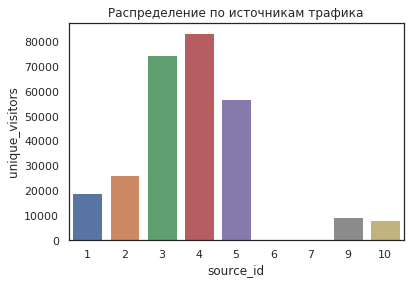

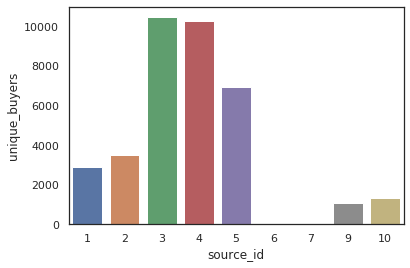

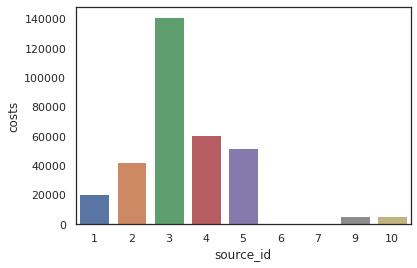

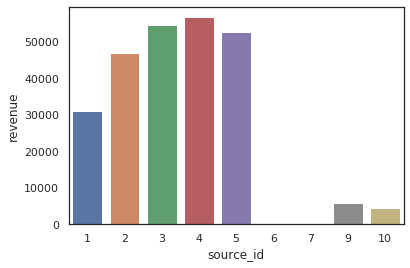

In [56]:
graphic = ['unique_visitors', 'unique_buyers', 'costs', 'revenue']
plt.title('Распределение по источникам трафика')
for i in graphic:
    sns.barplot(x='source_id', y=i, data=rev_uid_costs_per_source)
    plt.show()

In [57]:
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['unique_buyers']
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['price_for_client'].round(2)
cac_per_source = rev_uid_costs_per_source[['source_id', 'price_for_client']]
cac_per_source

,source_id,price_for_client
0,1,7.19
1,2,12.21
2,3,13.49
3,4,5.93
4,5,7.47
5,6,NaN
6,7,0.00
7,9,5.07
8,10,4.38


Самые большие затраты на одного покупателя у 2 и 3 источника, а самые низкие у 9 и 10.

In [58]:
rev_uid_costs_per_source['ltv'] = (rev_uid_costs_per_source['revenue']/rev_uid_costs_per_source['unique_buyers']).round(2)
rev_uid_costs_per_source['cac'] = (rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['unique_buyers']).round(2)
rev_uid_costs_per_source['romi'] = (rev_uid_costs_per_source['ltv']/rev_uid_costs_per_source['cac']).round(2)
rev_uid_costs_per_source

,source_id,costs,revenue,unique_visitors,unique_buyers,price_for_client,ltv,cac,romi
0,1,20833.27,31090.55,18999,2899,7.19,10.72,7.19,1.49
1,2,42806.04,46923.61,26245,3506,12.21,13.38,12.21,1.10
2,3,141321.63,54511.24,74756,10473,13.49,5.20,13.49,0.39
3,4,61073.60,56696.83,83525,10296,5.93,5.51,5.93,0.93
4,5,51757.10,52624.02,56974,6931,7.47,7.59,7.47,1.02
5,6,0.00,0.00,6,0,NaN,NaN,NaN,NaN
6,7,0.00,1.22,34,1,0.00,1.22,0.00,inf
7,9,5517.49,5759.40,9264,1088,5.07,5.29,5.07,1.04
8,10,5822.49,4450.33,8067,1329,4.38,3.35,4.38,0.76


1 источник самый окупаемый, также в + работают 2, 5 и 9. 3, 4 и 10 источники являются невыгодными с точки зрения окупаемости.

Рассчитаем ROMI по когортам в разрезе источников за 6 месяцев.

In [59]:
cohorts_sources = visits.groupby(['first_visit_month','source_id']).agg({'uid':'nunique'}) #когорты в разрезе источников

In [60]:
visits1 = visits[['uid', 'source_id']]
orders1 = orders[['uid', 'first_order_month', 'revenue', 'order_month']] 

In [61]:
visits_orders = orders.merge(first_source_per_user, on='uid')
visits_orders = visits_orders.sort_values(by='first_order_month')
visits_orders

,buy ts,revenue,uid,first_buy_ts,time_to_buy,first_order_month,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0,2017-06-01,2017-06-01,1
2951,2017-06-13 14:51:00,1.83,14276623213536302531,2017-06-13 14:51:00,0,2017-06-01,2017-06-01,2
2952,2017-06-13 14:52:00,3.05,13633448433817828853,2017-06-13 14:52:00,0,2017-06-01,2017-06-01,1
2953,2017-06-13 16:32:00,1.34,14515592047026750252,2017-06-13 16:32:00,0,2017-06-01,2017-06-01,1
2954,2017-06-13 16:35:00,36.67,7222047337331926235,2017-06-13 16:35:00,0,2017-06-01,2017-06-01,5
...,...,...,...,...,...,...,...,...
48251,2018-05-16 21:38:00,7.33,10873542796385792075,2018-05-16 21:38:00,0,2018-05-01,2018-05-01,9
48252,2018-05-16 21:41:00,6.11,749579814038202492,2018-05-16 21:41:00,0,2018-05-01,2018-05-01,5
48253,2018-05-16 21:43:00,6.11,8751176870152257755,2018-05-16 21:43:00,0,2018-05-01,2018-05-01,1
48243,2018-05-16 21:04:00,1.95,17567595666858227127,2018-05-16 21:04:00,0,2018-05-01,2018-05-01,2


In [62]:
visits_orders['age'] = (visits_orders['order_month'] - visits_orders['first_order_month']) / np.timedelta64(1, 'M')
visits_orders['age'] = visits_orders['age'].round().astype('int')
visits_orders = visits_orders[(visits_orders['first_order_month'] < '2017-12-01') & (visits_orders['age'] < 7)]
visits_orders

,buy ts,revenue,uid,first_buy_ts,time_to_buy,first_order_month,order_month,source_id,age
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,0,2017-06-01,2017-06-01,1,0
2951,2017-06-13 14:51:00,1.83,14276623213536302531,2017-06-13 14:51:00,0,2017-06-01,2017-06-01,2,0
2952,2017-06-13 14:52:00,3.05,13633448433817828853,2017-06-13 14:52:00,0,2017-06-01,2017-06-01,1,0
2953,2017-06-13 16:32:00,1.34,14515592047026750252,2017-06-13 16:32:00,0,2017-06-01,2017-06-01,1,0
2954,2017-06-13 16:35:00,36.67,7222047337331926235,2017-06-13 16:35:00,0,2017-06-01,2017-06-01,5,0
...,...,...,...,...,...,...,...,...,...
21383,2017-11-14 14:41:00,17.78,2057491363201392211,2017-11-14 14:41:00,0,2017-11-01,2017-11-01,4,0
21382,2017-11-14 14:37:00,16.50,6619426522903020330,2017-11-14 14:37:00,0,2017-11-01,2017-11-01,4,0
21381,2017-11-14 14:32:00,0.85,9280925860976790081,2017-11-14 14:32:00,0,2017-11-01,2017-11-01,2,0
21380,2017-11-14 14:22:00,4.28,11160456621339175950,2017-11-14 14:22:00,0,2017-11-01,2017-11-01,2,0


In [63]:
cohorts_visits_orders = visits_orders.groupby(['first_order_month','source_id']).agg({'revenue':'sum'})
cohorts_visits_orders

revenue
first_order_month source_id          
2017-06-01        1           4618.37
                  2           2659.65
                  3           3517.16
                  4           3916.33
                  5           3469.97
                  9            413.30
                  10           240.41
2017-07-01        1           2795.88
                  2           2182.67
                  3           3600.96
                  4           3135.50
                  5           2726.40
                  9            335.67
                  10           185.75
2017-08-01        1           1474.82
                  2            959.88
                  3           1989.69
                  4           2051.65
                  5           3385.41
                  7              1.22
                  9            329.60
                  10           201.27
2017-09-01        1           2160.98
                  2           5612.78
                  3           5227.43
                  4           4360.41
                  5          15284.36
                  9            704.23
                  10           223.64
2017-10-01        1           2741.02
                  2           4853.11
                  3           6505.00
                  4           5949.47
                  5           5586.32
                  9            882.78
                  10           584.61
2017-11-01        1           3295.77
                  2           3868.50
                  3           6067.78
                  4           7951.94
                  5           3607.99
                  9            656.32
                  10           650.69

In [64]:
cohorts_visits_orders.pivot_table(index = 'first_order_month', columns = 'source_id', values = 'revenue')

source_id,1,2,3,4,5,7,9,10
first_order_month,,,,,,,,
2017-06-01,4618.37,2659.65,3517.16,3916.33,3469.97,NaN,413.30,240.41
2017-07-01,2795.88,2182.67,3600.96,3135.50,2726.40,NaN,335.67,185.75
2017-08-01,1474.82,959.88,1989.69,2051.65,3385.41,1.22,329.60,201.27
2017-09-01,2160.98,5612.78,5227.43,4360.41,15284.36,NaN,704.23,223.64
2017-10-01,2741.02,4853.11,6505.00,5949.47,5586.32,NaN,882.78,584.61
2017-11-01,3295.77,3868.50,6067.78,7951.94,3607.99,NaN,656.32,650.69


In [65]:
costs['month'] = costs['dt'].astype('datetime64[M]') 
costs1 = costs[['month', 'costs', 'source_id']]
costs1.columns = ['first_order_month', 'costs', 'source_id']
costs2 = costs1.groupby(['first_order_month', 'source_id']).agg({'costs':'sum'})

In [66]:
report2 = cohorts_visits_orders.merge(costs2, on= ['first_order_month', 'source_id']).drop_duplicates()

In [67]:
client_per_source2 = orders.merge(first_source_per_user, on='uid')
client_per_source3 = client_per_source2.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'})

In [68]:
report2 = report2.merge(client_per_source3, on= ['first_order_month', 'source_id']).drop_duplicates()
report2

revenue     costs   uid
first_order_month source_id                          
2017-06-01        1           4618.37   1125.61   190
                  2           2659.65   2427.38   235
                  3           3517.16   7731.65   638
                  4           3916.33   3514.80   413
                  5           3469.97   2616.12   384
                  9            413.30    285.22    68
                  10           240.41    314.22    95
2017-07-01        1           2795.88   1072.88   160
                  2           2182.67   2333.11   208
                  3           3600.96   7674.37   512
                  4           3135.50   3529.73   517
                  5           2726.40   2998.14   423
                  9            335.67    302.54    52
                  10           185.75    329.82    51
2017-08-01        1           1474.82    951.81   113
                  2            959.88   1811.05   123
                  3           1989.69   6143.54   337
                  4           2051.65   3217.36   338
                  5           3385.41   2185.28   360
                  9            329.60    248.93    61
                  10           201.27    232.57    37
2017-09-01        1           2160.98   1502.01   227
                  2           5612.78   2985.66   221
                  3           5227.43   9963.55   781
                  4           4360.41   5192.26   590
                  5          15284.36   3849.14   589
                  9            704.23    415.62    87
                  10           223.64    460.67    86
2017-10-01        1           2741.02   2315.75   340
                  2           4853.11   4845.00   396
                  3           6505.00  15737.24  1152
                  4           5949.47   6420.84  1172
                  5           5586.32   5767.40   945
                  9            882.78    609.41   126
                  10           584.61    627.24   209
2017-11-01        1           3295.77   2445.16   324
                  2           3868.50   5247.68   398
                  3           6067.78  17025.34  1216
                  4           7951.94   5388.82  1177
                  5           3607.99   6325.34   693
                  9            656.32    683.18   145
                  10           650.69    792.36   128

In [69]:
report2['ltv'] = report2['revenue']/report2['uid']
report2['cac'] = report2['costs']/report2['uid']
report2['romi'] = report2['ltv']/report2['cac']
result2 = report2.pivot_table(index = 'first_order_month', columns='source_id', values='romi')
report2

revenue     costs   uid        ltv        cac  \
first_order_month source_id                                                   
2017-06-01        1           4618.37   1125.61   190  24.307211   5.924263   
                  2           2659.65   2427.38   235  11.317660  10.329277   
                  3           3517.16   7731.65   638   5.512790  12.118574   
                  4           3916.33   3514.80   413   9.482639   8.510412   
                  5           3469.97   2616.12   384   9.036380   6.812813   
                  9            413.30    285.22    68   6.077941   4.194412   
                  10           240.41    314.22    95   2.530632   3.307579   
2017-07-01        1           2795.88   1072.88   160  17.474250   6.705500   
                  2           2182.67   2333.11   208  10.493606  11.216875   
                  3           3600.96   7674.37   512   7.033125  14.989004   
                  4           3135.50   3529.73   517   6.064797   6.827331   
                  5           2726.40   2998.14   423   6.445390   7.087801   
                  9            335.67    302.54    52   6.455192   5.818077   
                  10           185.75    329.82    51   3.642157   6.467059   
2017-08-01        1           1474.82    951.81   113  13.051504   8.423097   
                  2            959.88   1811.05   123   7.803902  14.723984   
                  3           1989.69   6143.54   337   5.904125  18.230089   
                  4           2051.65   3217.36   338   6.069970   9.518817   
                  5           3385.41   2185.28   360   9.403917   6.070222   
                  9            329.60    248.93    61   5.403279   4.080820   
                  10           201.27    232.57    37   5.439730   6.285676   
2017-09-01        1           2160.98   1502.01   227   9.519736   6.616784   
                  2           5612.78   2985.66   221  25.397195  13.509774   
                  3           5227.43   9963.55   781   6.693252  12.757426   
                  4           4360.41   5192.26   590   7.390525   8.800441   
                  5          15284.36   3849.14   589  25.949677   6.535042   
                  9            704.23    415.62    87   8.094598   4.777241   
                  10           223.64    460.67    86   2.600465   5.356628   
2017-10-01        1           2741.02   2315.75   340   8.061824   6.811029   
                  2           4853.11   4845.00   396  12.255328  12.234848   
                  3           6505.00  15737.24  1152   5.646701  13.660799   
                  4           5949.47   6420.84  1172   5.076340   5.478532   
                  5           5586.32   5767.40   945   5.911450   6.103069   
                  9            882.78    609.41   126   7.006190   4.836587   
                  10           584.61    627.24   209   2.797177   3.001148   
2017-11-01        1           3295.77   2445.16   324  10.172130   7.546790   
                  2           3868.50   5247.68   398   9.719849  13.185126   
                  3           6067.78  17025.34  1216   4.989951  14.001102   
                  4           7951.94   5388.82  1177   6.756109   4.578437   
                  5           3607.99   6325.34   693   5.206335   9.127475   
                  9            656.32    683.18   145   4.526345   4.711586   
                  10           650.69    792.36   128   5.083516   6.190313   

                                 romi  
first_order_month source_id            
2017-06-01        1          4.102993  
                  2          1.095688  
                  3          0.454904  
                  4          1.114240  
                  5          1.326380  
                  9          1.449057  
                  10         0.765101  
2017-07-01        1          2.605958  
                  2          0.935520  
                  3          0.469219  
                  4          0.888312  
                  5          0.90

In [70]:
result2

source_id,1,2,3,4,5,9,10
first_order_month,,,,,,,
2017-06-01,4.102993,1.095688,0.454904,1.114240,1.326380,1.449057,0.765101
2017-07-01,2.605958,0.935520,0.469219,0.888312,0.909364,1.109506,0.563186
2017-08-01,1.549490,0.530013,0.323867,0.637681,1.549188,1.324067,0.865417
2017-09-01,1.438725,1.879913,0.524655,0.839790,3.970851,1.694408,0.485467
2017-10-01,1.183642,1.001674,0.413351,0.926587,0.968603,1.448581,0.932036
2017-11-01,1.347875,0.737183,0.356397,1.475637,0.570403,0.960684,0.821205


In [71]:
report2.groupby('first_order_month').agg({'romi' : 'sum'})

,romi
first_order_month,
2017-06-01,10.308363
2017-07-01,7.481064
2017-08-01,6.779723
2017-09-01,10.833810
2017-10-01,6.874474
2017-11-01,6.269383


In [72]:
report2.groupby('source_id').agg({'romi' : 'sum'})

,romi
source_id,
1,12.228684
2,6.179989
3,2.542393
4,5.882247
5,9.294788
9,7.986304
10,4.432411


В итоге имеем следующую картину: если рассматривать когорты, то самые высокие показатели romi у 1-ой и 4-ой когорты, а если рассмотреть источники, то самые большие показатели romi у 1-ого и 5-ого источника

### Вывод

В последнем этапе мы рассматрели маркетинговые метрики. Из нашего анализа делаем вывод, что 1-ый и 2-ой источник являются особо перспективными с точки зрения доходов, 4-ый источник самый перспективный с точки зрения привлечения покупателей, хоть он немного убыточен для компании, также можно рассмотреть и 5-ый источник, но по показателям клиентов он немного хуже 4-ого, а 3-ий источник имеет самые большие расходы и в итоге он совсем не окупается. Также  Следовательно, нужно перераспределить денежные вложение из 3-его источника в более перспективные. 

## Общий вывод

В конце, предлагаю вывести основные выводы, а также рекомендации.
1. Источники трафика.

Я предлагаю обратить внимание маркетологам на 3-ий источник, т.к. он совсем невыгоден компании по всем параметрам. В то же время мы имеем 1-ый и 5-ый источники, которые являются особо перспективными с точки зрения оккупаемости, а также 4-ый источник как самый перспективный с точки зрения привлечения покупателей, не смотря на то, что он немного убыточен. Эти выводы сделаны на основе параметров ltv, sas и romi, также на графиках можно было увидеть кол-во покупателей и посетителей сайта. След-но нужно перенаправить вложения из 3-его источника в более перспективные.

2. Продуктовые метрики, метрики электронной коммерции и маркетинговые метрики.

Начнем с продуктовых метрик. Мы нашли средние DAU: 907 пользователей, WAU: 5716 пользователей, MAU: 23228 пользователей. Узнали, что пользователи в среднем за день заходят 1 раз на сайт. Большинство сессий длятся около 1 минуты, т.е. люди в основном особо не задерживаются на сайте. Существенная часть пользователей не возвращаются на сайт после 1-ого посещения. А также, что retention rate довольно низкий и не превышает 9%, и на 2-ой месяц жизни когорты в среднем возращается 6.5%. Выделим июньскую когорту у неё самые высокие показатели retention. Поэтому я считаю, что специальстам нужно обратить на неё внимание.

Перейдем к метрике электронной коммерции. Мы узнали, что в среднем проходит 7 минут между 1-ым посещением и 1-ым заказом. В среднем покупатели осуществляют 1 покупку за 6 месяцев. Если рассматривать средний чек по когортам, то общий составляет около 15 у.е., а также стоит обратить внимание на когорты с самыми крупными чеками, т.е. на июньскую, сентябрьская и декабрьскую когорты 2017 года. И в итоге если рассматривать когорты, которые прожили не менее 6 месяцев, то самые большие доходы приносят  сентябрьская и июньская когорты, исходя из значений ltv. 

И в конце обсудим маркетинговые метрики. 3 источник имеет самые большие расходы. Также мы узнали, что в целом компания работает в минус, т.к. показатель САС больше показателя ltv по каждому пользователю. 1-ый и 2-ой источники являются хорошо окупаемыми. Остальные источники не окупаются, либо окупается в меньшей степени.

3. Перспективные когорты клиентов для компании.

Делаем вывод на основе анализа, что retention rate и ltv убывают с увеличением жизни когорты. Также каждая когорта имеет максимальную выручку в первый месяц своей жизни. Я бы выделил 2 когорты - июньскую и сентябрьскую. У июньской когорты высокий retention rate и ltv, поэтому её нужно доскональней рассмотреть. А сентябрьская имеет один из самых крупных средний чеков, а также аномально большой средний чек на 4-ом месяце жизни, следовательно её также нужно рассмотреть.